1. Get embeddings (resnet50)
2. knn ranking    (sklearn.neighbors.NearestNeighbors)


1. get embeddings   (resnet50)
2. classifier       (KNN)
3. knn within class (sklearn.neighbors.NearestNeighbors)


1. get embeddings           (AutoEncoder)
2. Dimensionality reduction (PCA)
3. classifier               (TripletLoss)
4. knn within class         (sklearn.neighbors.NearestNeighbors)


In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import copy
import tqdm
from io import BytesIO
import base64
import time

In [2]:
from imagesearch.utils import plot_confusion_matrix

In [3]:
# !python3 -m pip install seaborn
import seaborn as sn

In [4]:
# !pip3 install requests_aws4auth
# !pip3 install elasticsearch=='7.13.4' #https://opensearch.org/docs/clients/index/

In [5]:
image_folder = '/mnt/osn3/caceres/classes/geological/geological_similarity'

In [6]:
classes = [ 'andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

# Method 1: 
1. Get embeddings
2. knn ranking

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torchvision import transforms


In [10]:
def get_feature_extractor():
    featureExtractor = models.resnet50(pretrained=True)

    #     featureExtractor = models.vgg16(pretrained=True)
    #featureExtractor.load_state_dict(torch.load('/home/ccaceresgarcia/Documents/Projects/image_search/resnet50-19c8e357.pth')) # path of your weights

    featureExtractor.eval()
    # featureExtractor.cuda()

    modules=list(featureExtractor.children())[:-1]
    featureExtractor=nn.Sequential(*modules)
    for p in featureExtractor.parameters():
        p.requires_grad = False

    return featureExtractor

featureExtractor = get_feature_extractor()
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
featureExtractor = featureExtractor.to(device)
    
# resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# inception = models.inception_v3(pretrained=True)
# googlenet = models.googlenet(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet_v2 = models.mobilenet_v2(pretrained=True)
# mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
# mnasnet = models.mnasnet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ccaceresgarcia/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

In [44]:
def get_image(filename):
    image = Image.open(filename) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)
    return img
    
def get_rotation(img, k):
    img_rot = torch.rot90(img, k, [2, 3])
    return img_rot

def extract_feature_from_image(img):
    with torch.no_grad():
        feature = featureExtractor(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)
    return flat_feature

def get_rotated_featues_from_image(img):
    features = []
    for rot in range(4):
        img_rot = get_rotation(img, rot)
        flat_feature = extract_feature_from_image(img_rot)
        features.append(flat_feature)
    return features

def get_features_from_filename(filename, doaug=False):

    img = get_image(filename)
    if doaug:
        features = get_rotated_featues_from_image(img)
        flat_feature = np.average(features, axis=0)
    else:
        flat_feature = extract_feature_from_image(img)

    return flat_feature

def get_class(x):
    return os.path.split(os.path.split(x)[0])[1]

## Get features

In [13]:

features = {}
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
    features[i] = []
    
    for filename in image_list:
        flat_feature = get_features_from_filename(filename)
        features[i].append((flat_feature, label, filename))

/home/ccaceresgarcia/miniconda3/envs/spot4/lib/python3.6/site-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629416375/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


## Split into train/test

In [14]:
test_perc = 0.2

train_set = []
test_set = []
for k,v in features.items():
    random.shuffle(v)
    test_count = int(test_perc * len(v))
    test_set.extend(v[:test_count])
    train_set.extend(v[test_count:])

In [15]:
len(train_set), len(test_set)

(23999, 5999)

In [16]:
for k,v in features.items():
    print(k, len(v))

0 5000
1 5000
2 4998
3 5000
4 5000
5 5000


In [17]:
train_features, train_labels, train_filenames = list(zip(*train_set))
test_features, test_labels, test_filenames = list(zip(*test_set))

In [18]:
train_features = np.array(train_features)
test_features = np.array(test_features)

train_features.shape, test_features.shape

((23999, 2048), (5999, 2048))

In [19]:
train_feats_backup = copy.deepcopy(train_features)
test_features_backup = copy.deepcopy(test_features)

In [20]:
scale = False #'standard'
use_pca = False
pca_n_components = 1000
save_file = False
test_time_aug = True

In [21]:
train_features = train_feats_backup
test_features  = test_features_backup

## Scale features

In [22]:
if scale:
    #Rescaling features age, trestbps, chol, thalach, oldpeak.
    if scale == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    elif scale == 'standard':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    else:
        raise ValuError('Not supported scaler')
        
    # scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    # we must apply the scaling to the test set that we computed for the training set
    test_features = scaler.transform(test_features)

# Perform pca

In [23]:
if use_pca:
    import numpy as np
    from sklearn.decomposition import PCA

    pca = PCA(n_components=pca_n_components)#'mle')
    pca.fit(train_features) # n_samples, n_features

    #print(pca.explained_variance_ratio_),print(pca.singular_values_)

    #print(pca.singular_values_.shape)

    train_features = pca.transform(train_features)
    test_features = pca.transform(test_features)

## Write vectors to file for s3 upload

In [24]:
if save_file:
    f3 = [str(list(x)) for x in features]

    import csv

    with open("resnet_vectors.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(f3)

    label_features = {}
    for i, label in enumerate(classes):
        label_features[i] = [(x, name) for name,x, la in zip(filenames, f3, labels) if la == label]

    ### Per Class files

    for i, label in enumerate(classes):
        f4, lab_names = zip(*label_features[i])

        feature_data = {'labels':label, 
                    'filenames':lab_names,
                    'features':f4}

        with open('resnet_vectors_{}.json'.format(label), 'w') as f:
            json.dump(feature_data, f)

    feature_data = {'labels':labels, 
                    'filenames':filenames,
                    'features':f3}

    import json
    with open('resnet_vectors.json', 'w') as f:
        json.dump(feature_data, f)

## Make KNN object

In [25]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=30, algorithm='brute',metric='euclidean').fit(train_features)

In [26]:
if save_file:
    import pickle 

    # Its important to use binary mode 
    knnPickle = open('knnpickle_file', 'wb') 

    # source, destination 
    pickle.dump(neighbors, knnPickle)                      

    # load the model from disk
    loaded_model = pickle.load(open('knnpickle_file.pickle', 'rb'))
    
    with open('filenames.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(filenames, f, pickle.HIGHEST_PROTOCOL)

    with open('filenames.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        loaded_filenames = pickle.load(f)

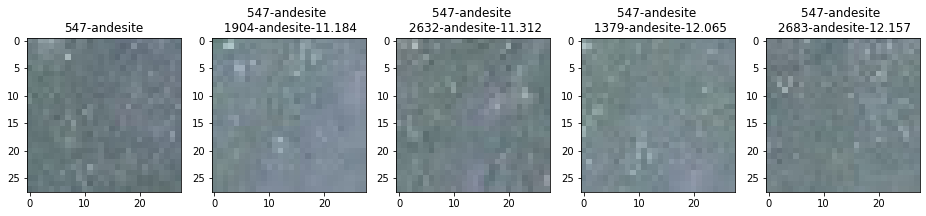

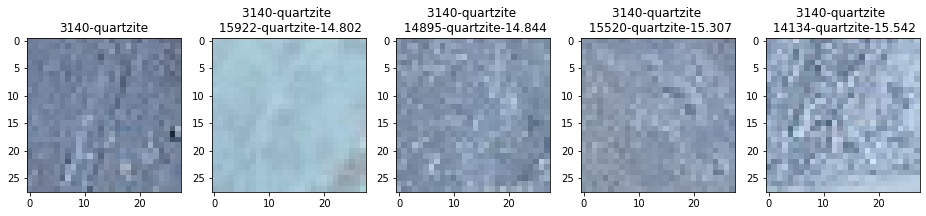

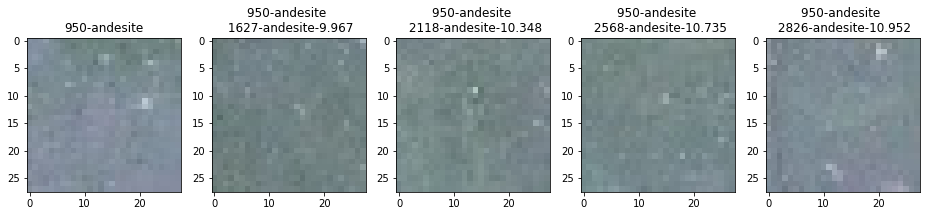

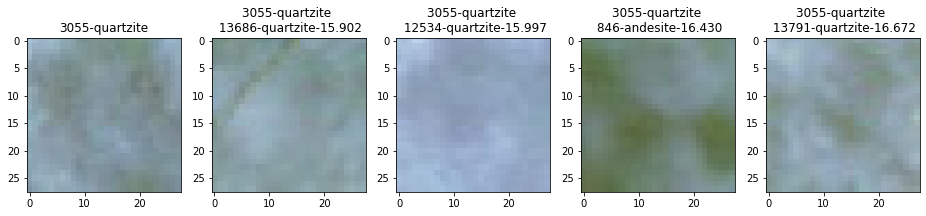

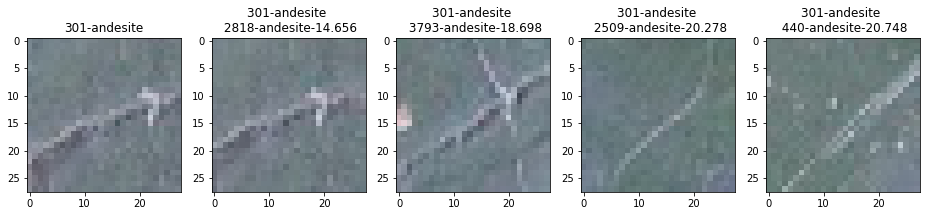

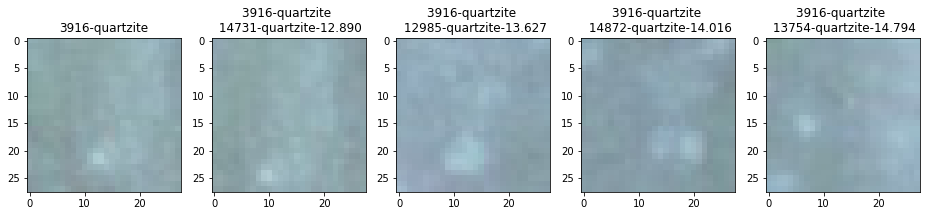

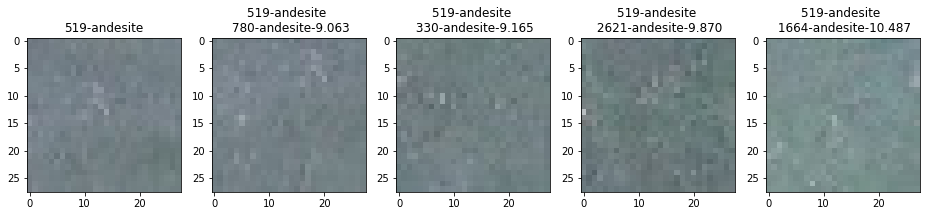

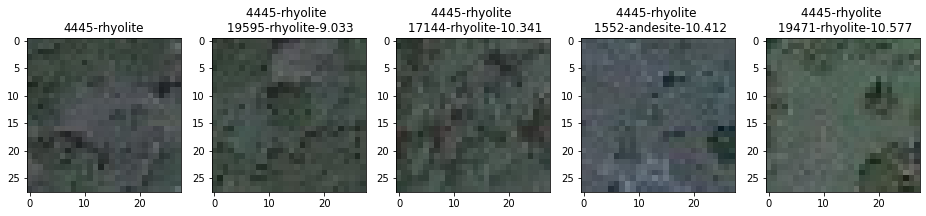

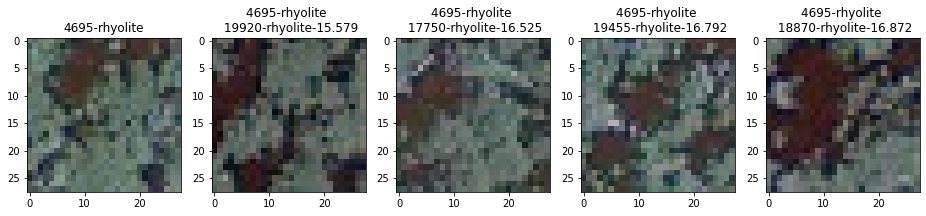

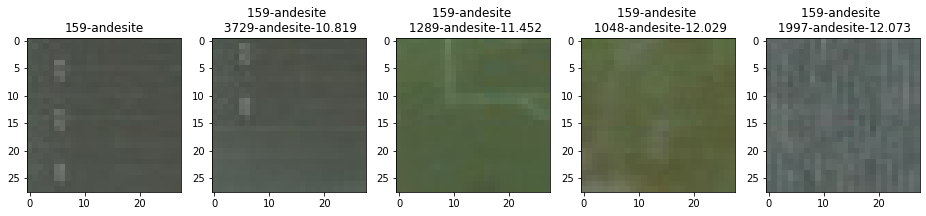

In [27]:
k=4
for query in [random.randint(0,len(test_filenames)-1) for _ in range(10)]:
    
    4186, 1260,4617,2387,1909,2544,5224,5566,4132,2139
    # get embedding
    flat_feature = get_features_from_filename(test_filenames[query])
    
    flat_feature = flat_feature[None,:] #.reshape(1, -1)
    
    if scale:
        flat_feature = scaler.transform(flat_feature)
            
    if use_pca:
        #print(t.shape)
        flat_feature = pca.transform(flat_feature)
        #print(flat_feature.shape)

    # Do KNN ranking
    distances, indices = neighbors.kneighbors(flat_feature)

    im = np.asarray(Image.open(test_filenames[query])) # read image
    
    # display results
    _, axes = plt.subplots(1,k+1,figsize=(16,4))
    axes.flat[0].imshow(im)
    axes.flat[0].set_title('{}-{}'.format(query, test_labels[query]))
    for i in range(k):
        # load the image
        match = indices[0][i]
        image = Image.open(train_filenames[match])
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i+1].imshow(im)
        axes.flat[i+1].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              test_labels[query], 
                                                              match, 
                                                              train_labels[match], 
                                                              distances[0][i]))


In [28]:
# k=4
# for query in [4186, 1260,4617,2387,1909,2544,5224,5566,4132,2139]:
    

#     img = get_image(test_filenames[query])
#     distances = []
#     indices = []
#     for rot in range(4):
#         img_rot = get_rotation(img, rot)
#         flat_feature = extract_feature_from_image(img_rot)
#         flat_feature = flat_feature[None,:] #.reshape(1, -1)

#         if scale:
#             flat_feature = scaler.transform(flat_feature)

#         if use_pca:
#             #print(t.shape)
#             flat_feature = pca.transform(flat_feature)
#             #print(flat_feature.shape)

#         dists, inds = neighbors.kneighbors(flat_feature)
#         distances.extend(list(dists[0]))
#         indices.extend(list(inds[0]))

#     zipped = sorted(zip(indices,distances), key = lambda x: x[1], reverse=False)
#     distances = [x[1] for x in zipped]
#     indices = [x[0] for x in zipped]


#     im = np.asarray(Image.open(test_filenames[query])) # read image
    
#     # display results
#     _, axes = plt.subplots(1,k+1,figsize=(16,4))
#     axes.flat[0].imshow(im)
#     axes.flat[0].set_title('{}-{}'.format(query, test_labels[query]))
#     for i in range(k):
#         # load the image
#         match = indices[i]
#         image = Image.open(train_filenames[match])
#         # convert image to numpy array
#         im = np.asarray(image)
#         axes.flat[i+1].imshow(im)
#         axes.flat[i+1].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
#                                                               test_labels[query], 
#                                                               match, 
#                                                               train_labels[match], 
#                                                               distances[i]))


In [29]:
flat_feature.shape

(1, 2048)

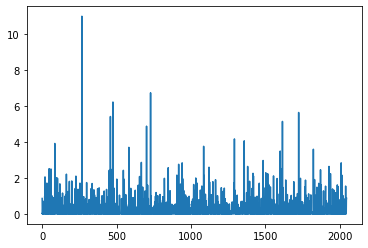

In [30]:
plt.plot(flat_feature.reshape(-1))

In [31]:

def calculate_accuracy(train_filenames, test_filenames, k=5, test_time_aug=False):
    correct = np.zeros((len(test_filenames), k))
    mistakes = {}
    for j in range(k):
        mistakes[j] = []
        
    for i in range(len(test_filenames)):

        test_file = test_filenames[i]
        
        if test_time_aug:
            img = get_image(test_file)
            distances = []
            indices = []
            for rot in range(4):
                img_rot = get_rotation(img, rot)
                flat_feature = extract_feature_from_image(img_rot)
                flat_feature = flat_feature[None,:] #.reshape(1, -1)

                if scale:
                    flat_feature = scaler.transform(flat_feature)

                if use_pca:
                    #print(t.shape)
                    flat_feature = pca.transform(flat_feature)
                    #print(flat_feature.shape)

                dists, inds = neighbors.kneighbors(flat_feature)
                distances.extend(list(dists[0]))
                indices.extend(list(inds[0]))

            zipped = sorted(zip(indices,distances), key = lambda x: x[1], reverse=False)
            distances = [x[1] for x in zipped]
            indices = [x[0] for x in zipped]
        else:
        
            flat_feature = get_features_from_filename(test_file)
            flat_feature = flat_feature[None,:] #.reshape(1, -1)

            if scale:
                flat_feature = scaler.transform(flat_feature)

            if use_pca:
                #print(t.shape)
                flat_feature = pca.transform(flat_feature)
                #print(flat_feature.shape)

            distances, indices = neighbors.kneighbors(flat_feature)
            distances = distances[0]
            #print(len(indices[0]))
        
        for j in range(k):
            match_file = train_filenames[indices[j]]
            match = int(get_class(match_file) == get_class(test_file))
            correct[i][j] = match
            if not match:
                mistakes[j].append((test_file, match_file))
                
    return correct, mistakes

# pca: False, scale: False, samples: 5999, took: 2744.519884109497
#  [0.896, 0.873, 0.861, 0.859, 0.855, 0.842, 0.847, 0.846, 0.84, 0.836, 0.837] 0.4574962300565923


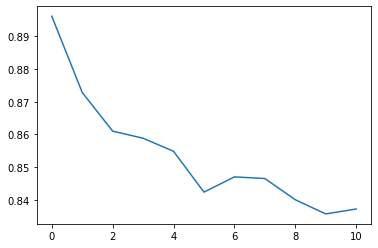

In [32]:
k = 11
ts = time.time()
acc, mistakes = calculate_accuracy(train_filenames, test_filenames, k=11, test_time_aug=test_time_aug) 
ttime = time.time() - ts
if use_pca:
    p = pca_n_components
else:
    p = use_pca
print('# pca: {}, scale: {}, samples: {}, took: {}'.format(p, scale, acc.shape[0], ttime))
    
# Resnet50:
    # scale: False
        # pca: False, scale: False, samples: 5999, took: 983.103
        # [0.90, 0.88, 0.864, 0.854, 0.855, 0.847, 0.846, 0.839, 0.84, 0.84, 0.84]

        # pca: 1000, scale: False, samples: 5999, took: 481.2866554260254
        # [0.902, 0.882, 0.864, 0.854, 0.856, 0.847, 0.841, 0.843, 0.842, 0.838, 0.842]

        # pca: 500, scale: False, samples: 5999, took: 242.25196051597595
        # [0.901,0.883,0.869,,0.852, 0.855,,0.85,0.842, 0.844, 0.844,  0.837, 0.839]

        # pca: 100, scale: False, samples: 5999, took: 102.55768990516663
        # [0.9, 0.874, 0.867, 0.858, 0.845, 0.850, 0.846, 0.844, 0.84, 0.842, 0.835]

    # scale: MinMax
        # pca: False, scale: minmax, samples: 5999, took: 989.081835269928
        #  [0.899, 0.876, 0.86, 0.861, 0.853, 0.844, 0.843, 0.834, 0.841, 0.836, 0.833] 0.16487445162025804

        # pca: 1000, scale: minmax, samples: 5999, took: 478.40618443489075
        # [0.9, 0.873, 0.86, 0.863, 0.854, 0.847, 0.845, 0.838, 0.842, 0.835, 0.835] 0.07974765534837319

        # pca: 100, scale: minmax, samples: 5999, took: 101.44189739227295
        #  [0.892, 0.871, 0.867, 0.86, 0.853, 0.848, 0.846, 0.84, 0.834, 0.833, 0.836] 0.016909801198911976

        # pca: 50, scale: minmax, samples: 5999, took: 82.11926007270813
        #  [0.887, 0.868, 0.866, 0.854, 0.848, 0.842, 0.839, 0.834, 0.834, 0.83, 0.835] 0.013688824816254065

        # pca: 10, scale: minmax, samples: 5999, took: 71.63585662841797
        #  [0.831, 0.821, 0.818, 0.801, 0.795, 0.802, 0.796, 0.788, 0.784, 0.787, 0.794] 0.011941299654678775

        # pca: 2, scale: minmax, samples: 5999, took: 68.28643941879272
        #  [0.462, 0.464, 0.461, 0.464, 0.456, 0.457, 0.463, 0.468, 0.459, 0.459, 0.454] 0.011382970398198487

    # scale: Standard
        # pca: False, scale: standard, samples: 5999, took: 974.3976526260376
        #  [0.89, 0.868, 0.852, 0.848, 0.845, 0.842, 0.83, 0.832, 0.828, 0.829, 0.823] 0.16242667988432033

# Resnet101:
    # pca: 1000, scale: False, samples: 5999, took: 523.0417103767395
    #  [0.874, 0.857, 0.839, 0.835, 0.825, 0.822, 0.814, 0.808, 0.806, 0.801, 0.796] 0.08718814975441565

# resnet18 512
    # pca: False, scale: False, samples: 5999, took: 208.6509552001953
    #  [0.89, 0.868, 0.856, 0.851, 0.84, 0.831, 0.829, 0.822, 0.826, 0.816, 0.813] 0.03478095602603689

# resnet18 512, Rotation augmentation
    # pca: False, scale: False, samples: 5999, took: 239.15582919120789
    #  [0.938, 0.923, 0.914, 0.896, 0.896, 0.886, 0.884, 0.88, 0.878, 0.87, 0.869] 0.03986594919006633
    
# resnet18, test time aug
    # pca: False, scale: False, samples: 5999, took: 635.116785287857
    #  [0.887, 0.866, 0.853, 0.846, 0.842, 0.833, 0.83, 0.83, 0.826, 0.828, 0.816] 0.10587044262174647

# resnet50, test time aug
    # pca: False, scale: False, samples: 5999, took: 2744.519884109497
    #  [0.896, 0.873, 0.861, 0.859, 0.855, 0.842, 0.847, 0.846, 0.84, 0.836, 0.837] 0.4574962300565923
    
ksum = acc.sum(0)/acc.shape[0]
print('# ', [round(x, 3) for x in ksum], ttime/(acc.shape[0]))
plt.plot(ksum)

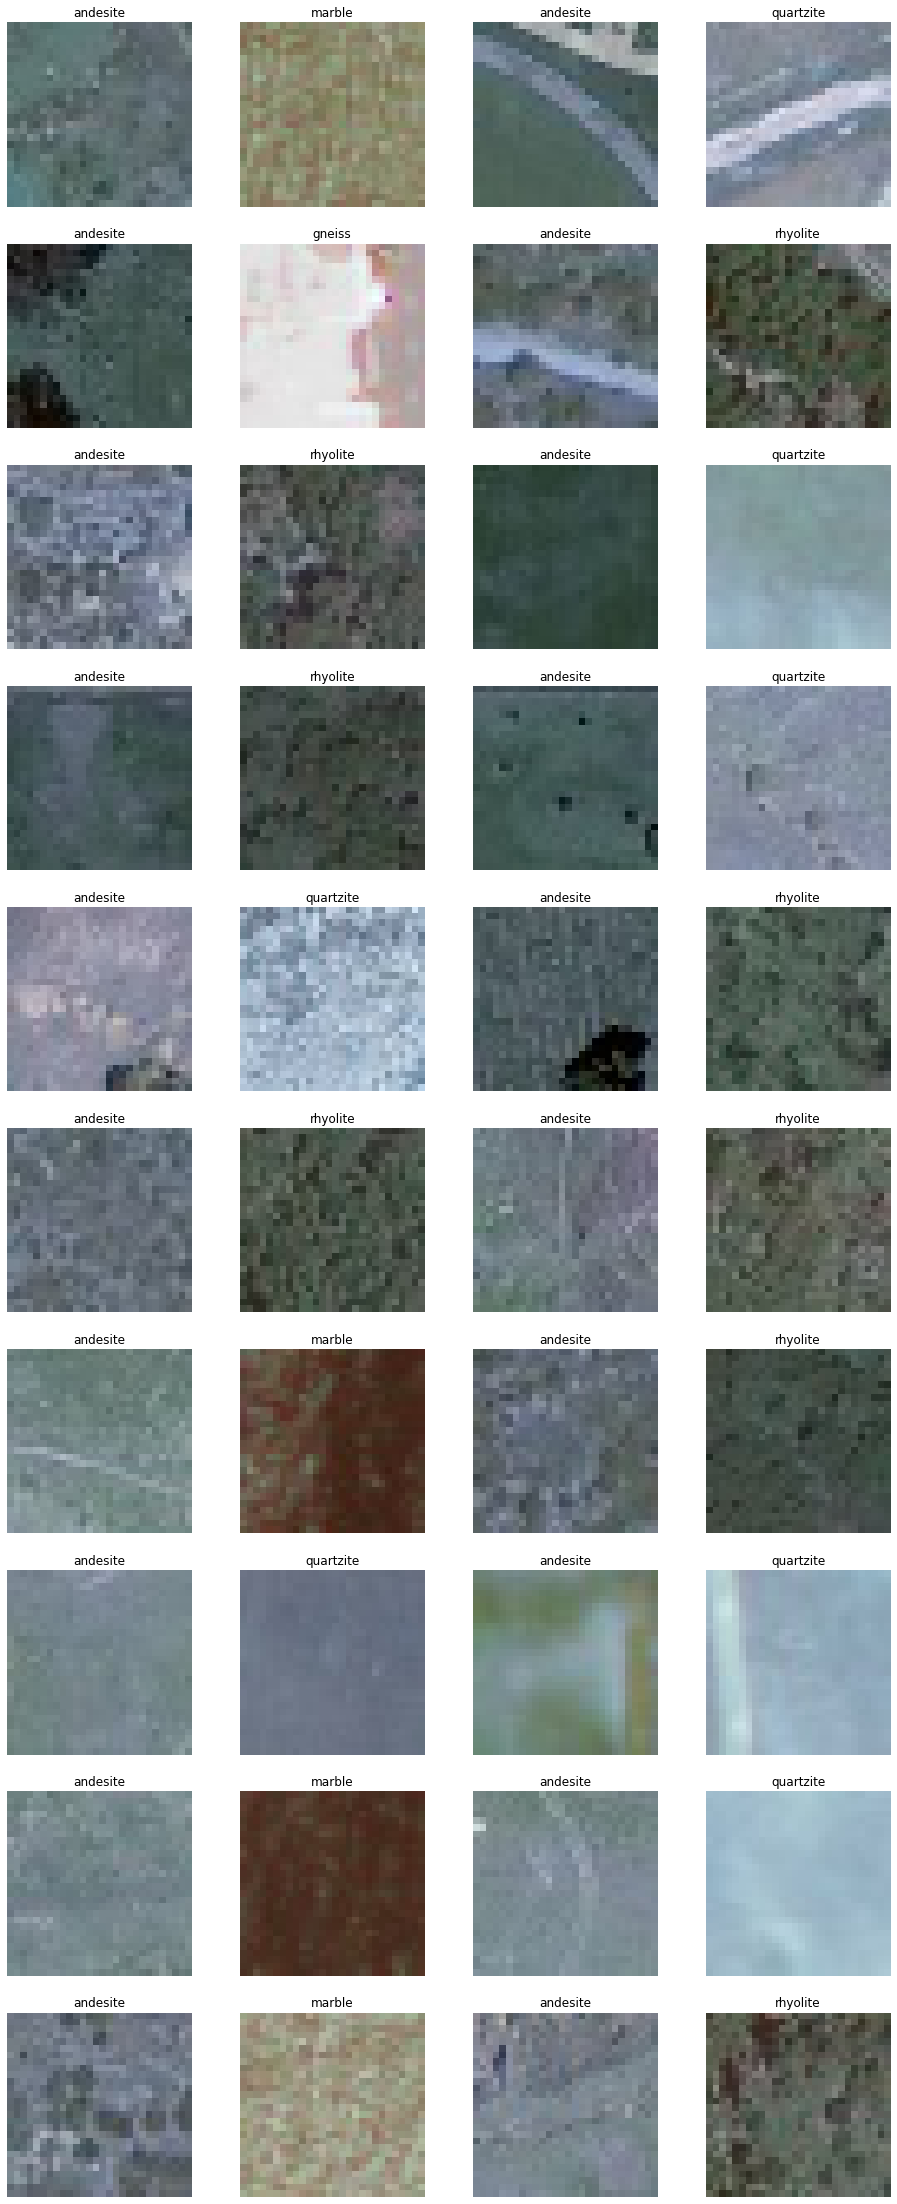

In [33]:
_, axes = plt.subplots(10,4,figsize=(16,40))
c = 0
for i in range(len(mistakes[0])):
    # load the image
    for j in range(2):
        filename = mistakes[0][i][j]
        image = Image.open(filename)
        im = np.asarray(image)
        axes.flat[c].imshow(im)
        axes.flat[c].set_title('{}'.format(get_class(filename)))
        axes.flat[c].set_axis_off()

        c+=1
    if c ==40:
        break

In [ ]:
breakhere minmax

# Method 2:
1. get embeddings
2. classifier
3. knn within class


In [ ]:
use_pca = False

## Get feature vectors

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [43]:
test_set

[(array([0.43950635, 0.03985556, 1.3352557 , ..., 0.        , 0.        ,
         1.4270521 ], dtype=float32),
  'andesite',
  '/mnt/osn3/caceres/classes/geological/geological_similarity/andesite/WZNVO.jpg'),
 (array([0.48278224, 0.        , 0.81542563, ..., 0.08640288, 0.5836426 ,
         0.8130844 ], dtype=float32),
  'andesite',
  '/mnt/osn3/caceres/classes/geological/geological_similarity/andesite/DZEO5.jpg'),
 (array([0.7062371, 0.       , 1.1881188, ..., 0.6786746, 1.8360505,
         0.656536 ], dtype=float32),
  'andesite',
  '/mnt/osn3/caceres/classes/geological/geological_similarity/andesite/Y8BR2.jpg'),
 (array([0.46228233, 0.        , 1.077412  , ..., 0.49202466, 1.1183718 ,
         0.73475754], dtype=float32),
  'andesite',
  '/mnt/osn3/caceres/classes/geological/geological_similarity/andesite/VEQUC.jpg'),
 (array([0.7724998 , 0.02259311, 0.75095093, ..., 0.01659837, 0.2525515 ,
         0.3715985 ], dtype=float32),
  'andesite',
  '/mnt/osn3/caceres/classes/geological/

In [ ]:

labels = []
filenames = []
features = {}
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
    features[i] = []
    
    for filename in image_list:
        flat_feature = get_features_from_filename(filename)
        features[i].append((flat_feature, label, filename))

## Split into train/test

In [ ]:
test_perc = 0.2

train_set = []
test_set = []
for k,v in features.items():
    random.shuffle(v)
    test_count = int(test_perc * len(v))
    test_set.extend(v[:test_count])
    train_set.extend(v[test_count:])

In [42]:
len(train_set), len(test_set)

(23999, 5999)

In [ ]:
for k,v in features.items():
    print(k, len(v))

In [ ]:
train_features, train_labels, train_filenames = list(zip(*train_set))
test_features, test_labels, test_filenames = list(zip(*test_set))

In [51]:
def get_augmented_train_set(filenames):
    all_features = []
    all_filenames = []
    all_labels = []
    for filename in filenames:
        img = get_image(filename)
        rotated_features = get_rotated_featues_from_image(img)
        label = get_class(filename)
        t = [filename]*4
        all_filenames.extend(t)
        t = [label]*4
        all_labels.extend(t)
        all_features.extend(rotated_features)
    return all_features, all_filenames, all_labels

In [52]:
all_features, all_filenames, all_labels = get_augmented_train_set(train_filenames)

In [54]:
len(all_filenames), len(all_labels), len(all_features)

(95996, 95996, 95996)

In [58]:
train_features = np.array(all_features)
train_labels = all_labels
# train_features = np.array(train_features)

In [67]:
train_filenames = all_filenames

In [57]:
test_features = np.array(test_features)

train_features.shape, test_features.shape

((95996, 2048), (5999, 2048))

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_features)

# train_features = scaler.transform(train_features)
# test_features = scaler.transform(test_features)

## PCA

In [ ]:
if use_pca:
    import numpy as np
    from sklearn.decomposition import PCA

    pca = PCA(n_components=500)#'mle')
    pca.fit(train_features) # n_samples, n_features

    print(pca.explained_variance_ratio_),print(pca.singular_values_)

    print(pca.singular_values_.shape)

    train_features = pca.transform(train_features)
    test_features = pca.transform(test_features)


## Train multiclass classifier

In [38]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
clf.fit(train_features, train_labels)

# Predict the value of the digit on the test subset
predicted = clf.predict(test_features)

In [60]:
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

    andesite       0.91      0.93      0.92      1000
      gneiss       0.94      0.96      0.95      1000
      marble       1.00      0.99      0.99       999
   quartzite       0.96      0.92      0.94      1000
    rhyolite       0.96      0.96      0.96      1000
      schist       0.95      0.95      0.95      1000

    accuracy                           0.95      5999
   macro avg       0.95      0.95      0.95      5999
weighted avg       0.95      0.95      0.95      5999



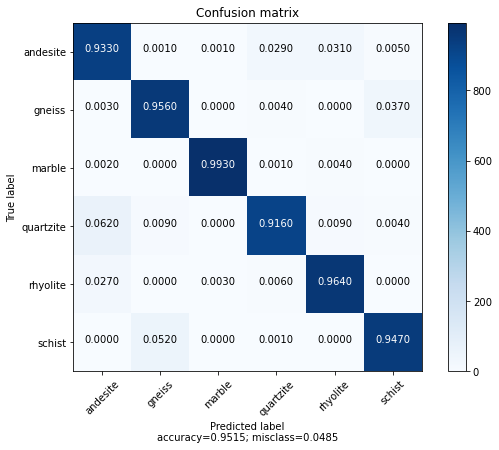

In [61]:
plot_confusion_matrix(confusion_matrix(test_labels, predicted), classes)

In [62]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [63]:
y_pred = classifier.predict(test_features)

In [64]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

    andesite       0.83      0.90      0.86      1000
      gneiss       0.90      0.93      0.91      1000
      marble       0.97      0.98      0.98       999
   quartzite       0.92      0.83      0.87      1000
    rhyolite       0.93      0.93      0.93      1000
      schist       0.94      0.91      0.92      1000

    accuracy                           0.91      5999
   macro avg       0.91      0.91      0.91      5999
weighted avg       0.91      0.91      0.91      5999



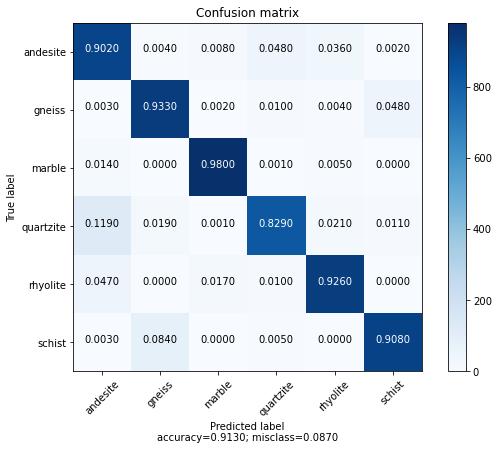

In [65]:
plot_confusion_matrix(confusion_matrix(test_labels, y_pred), classes)

## Make nearest neighbors for each cluster

In [68]:
from sklearn.neighbors import NearestNeighbors

k = 10
class_filenames = {}
class_labels = {}
neighbors = {}
for i, label in enumerate(classes):
    label_features = train_features[[x == label for x in train_labels]]
    
    neighbors[i] = NearestNeighbors(n_neighbors=k, algorithm='brute',metric='euclidean').fit(label_features)

    class_filenames[i] = list(np.array(train_filenames)[[x == label for x in train_labels]])
    class_labels[i] = list(np.array(train_labels)[[x == label for x in train_labels]])
    

# Query

4341 rhyolite /mnt/osn3/caceres/classes/geological/geological_similarity/rhyolite/DFJX8.jpg  --  4 rhyolite
4276 rhyolite /mnt/osn3/caceres/classes/geological/geological_similarity/rhyolite/NHRMB.jpg  --  4 rhyolite
2333 marble /mnt/osn3/caceres/classes/geological/geological_similarity/marble/ICUP8.jpg  --  2 marble
2986 marble /mnt/osn3/caceres/classes/geological/geological_similarity/marble/DWCLS.jpg  --  2 marble
3024 quartzite /mnt/osn3/caceres/classes/geological/geological_similarity/quartzite/YR53T.jpg  --  3 quartzite
1486 gneiss /mnt/osn3/caceres/classes/geological/geological_similarity/gneiss/PIOS0.jpg  --  1 gneiss
1237 gneiss /mnt/osn3/caceres/classes/geological/geological_similarity/gneiss/115PG.jpg  --  1 gneiss
1051 gneiss /mnt/osn3/caceres/classes/geological/geological_similarity/gneiss/ULE5Y.jpg  --  1 gneiss
2052 marble /mnt/osn3/caceres/classes/geological/geological_similarity/marble/LUDID.jpg  --  2 marble
5773 schist /mnt/osn3/caceres/classes/geological/geological_s

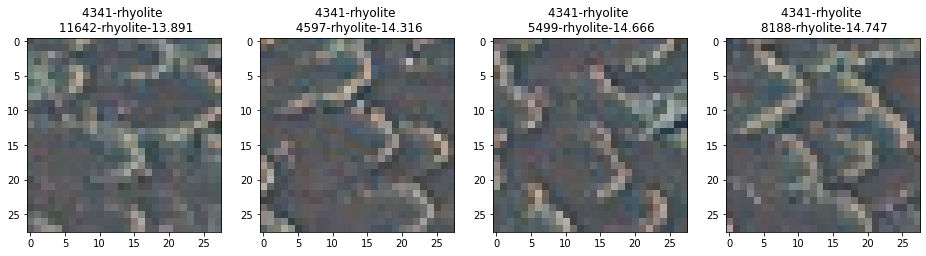

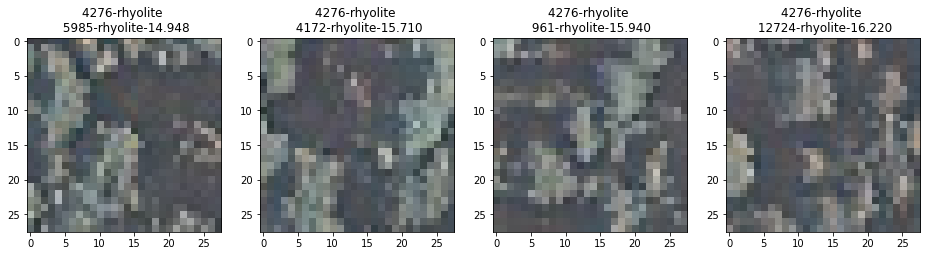

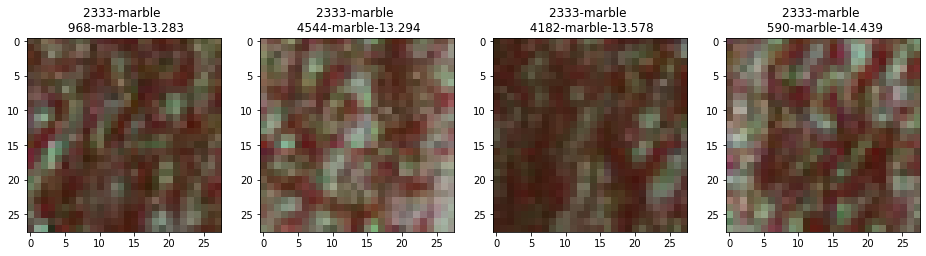

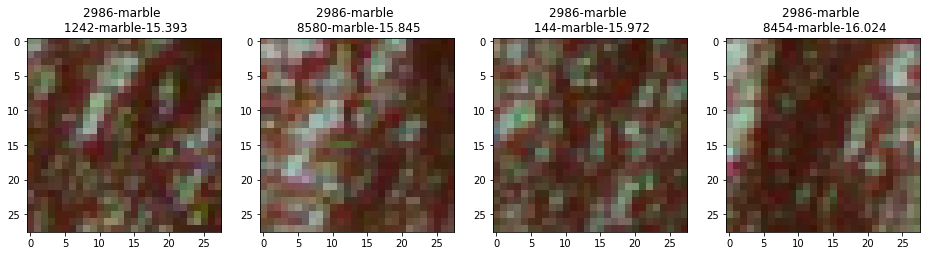

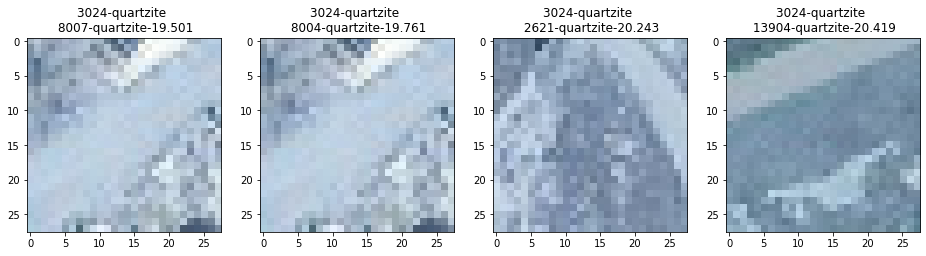

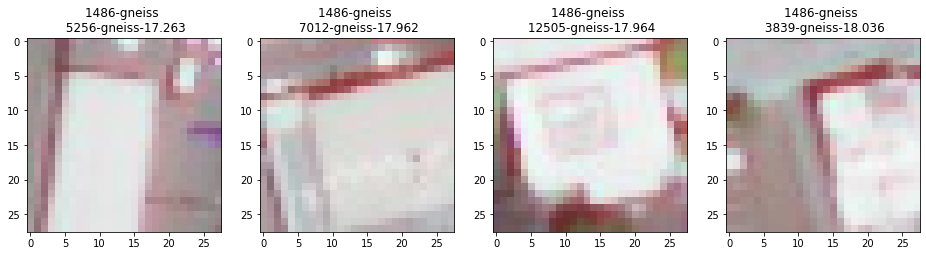

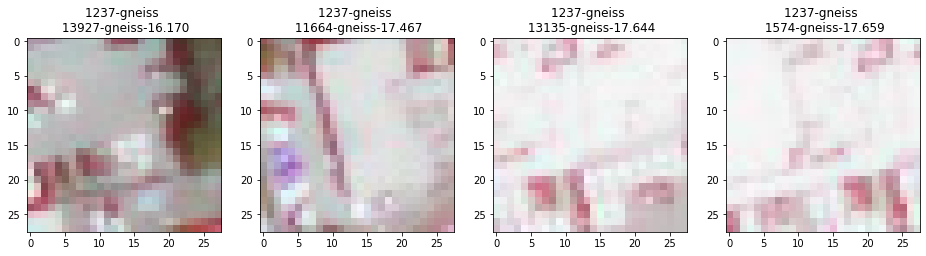

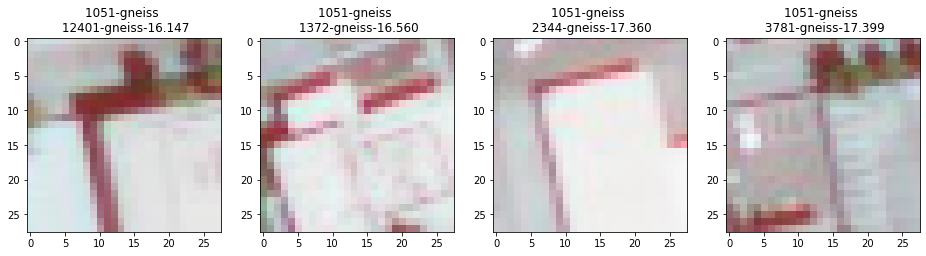

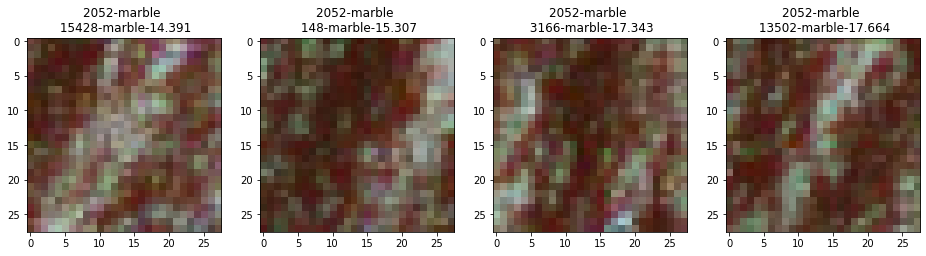

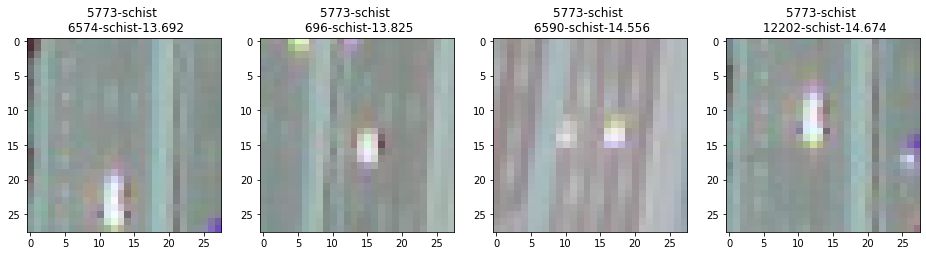

In [69]:
k=4
for query in [random.randint(0,len(test_filenames)-1) for _ in range(10)]:
    
    # get embedding
    flat_feature = get_features_from_filename(test_filenames[query])

    if scale:
        flat_feature = scaler.transform(flat_feature)
            
    if use_pca:
        flat_feature = pca.transform([flat_feature])[0]

    # classify    
    y_pred = clf.predict([flat_feature])
    
    best_class = [i for i,x in enumerate(classes) if x==y_pred[0]][0]
    print(query, test_labels[query], test_filenames[query], ' -- ', best_class, classes[best_class])
    
    # Do KNN ranking
    distances, indices = neighbors[best_class].kneighbors([test_features[query]])

    # display results
    _, axes = plt.subplots(1,k,figsize=(16,4))
    for i in range(k):
        # load the image
        match = indices[0][i]
        image = Image.open(class_filenames[best_class][match])
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i].imshow(im)
        axes.flat[i].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              test_labels[query], 
                                                              match, 
                                                              class_labels[best_class][match], 
                                                              distances[0][i]))


In [70]:
len(test_filenames), len(train_filenames)

(5999, 95996)

In [71]:

def calculate_accuracy(filenames, class_filenames, k=5):
    correct = np.zeros((len(filenames), k))
    for i in range(len(filenames)):

        flat_feature = get_features_from_filename(filenames[i])

        if scale:
            flat_feature = scaler.transform(flat_feature)

        if use_pca:
            flat_feature = pca.transform([flat_feature])[0]

        # classify    
        y_pred = clf.predict([flat_feature])

        best_class = [i for i,x in enumerate(classes) if x==y_pred[0]][0]
        #print(filenames[i], classes[best_class])

        # Do KNN ranking
        distances, indices = neighbors[best_class].kneighbors([flat_feature])

        #print(len(indices[0]))
        for j in range(k):
            correct[i][j] = int(get_class(class_filenames[best_class][indices[0][j]]) == get_class(filenames[i]))
    return correct


In [72]:
ts = time.time()
acc = calculate_accuracy(test_filenames,class_filenames, 10) 
ttime = time.time() - ts


# pca: False, scale: False, samples: 5999, took: 715.5501248836517
#  [0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951] 0.11927823385291744


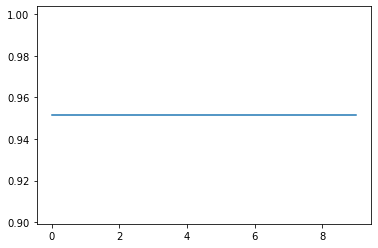

In [73]:
if use_pca:
    p = pca_n_components
else:
    p = use_pca
print('# pca: {}, scale: {}, samples: {}, took: {}'.format(p, scale, acc.shape[0], ttime))
          
ksum = acc.sum(0)/acc.shape[0]
print('# ', [round(x, 3) for x in ksum], ttime/(acc.shape[0]))
plt.plot(ksum)


# pca: False, scale: False, samples: 5999, took: 149.57762002944946
#  [0.936, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936, 0.936] 0.0249337589647357

# pca: False, scale: False, samples: 5999, took: 715.5501248836517
#  [0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951] 0.11927823385291744